# Imports

In [35]:
from transformers import pipeline 
import requests
from datetime import datetime, timedelta
import feedparser
from bs4 import BeautifulSoup

# Collect Data

In [4]:
# Move to constants file later on
rss_url_list=[
  "https://moxie.foxnews.com/google-publisher/latest.xml",
  "https://moxie.foxnews.com/google-publisher/world.xml",
  "https://moxie.foxnews.com/google-publisher/politics.xml",
  "https://moxie.foxnews.com/google-publisher/science.xml",
  "https://moxie.foxnews.com/google-publisher/health.xml",
  "https://moxie.foxnews.com/google-publisher/sports.xml",
  "https://moxie.foxnews.com/google-publisher/travel.xml",
  "https://moxie.foxnews.com/google-publisher/tech.xml",
  ]

In [5]:
# Function to fetch articles from News RSS Feed
def fetch_news_articles(feed_url):
    total_count = 0
    feed = feedparser.parse(feed_url)
    articles = []
    for entry in feed.entries:
        # total_count +=1
        articles.append({
            'title': entry.title,
            'description': entry.description,
            'content': entry.content[0].value})

    return articles

# Iterate over all rss urls
articles = []
for url in rss_url_list:
  articles += fetch_news_articles(url)


In [6]:
print('Number of articles',len(articles))
for article in articles:
    print(article)

Number of articles 200
{'title': "Former NFL star Drew Brees anxious to take another stab at broadcasting: 'Come get me'", 'description': 'Although Drew Brees&apos; stint as a broadcaster lasted just one year, he is now making it clear he is itching to take another shot at the job.', 'content': '<p>Drew Brees\' impressive <a href="https://www.foxnews.com/category/sports/nfl" rel="noopener" target="_blank">NFL career</a> came to an end after the 2020 season.</p><p>He spent the next NFL season working as a color analyst. Brees worked in the booth alongside NBC\'s play-by-play announcer, Mike Tirico, for a pair of games during his stint at the network. He also worked on <a href="https://www.foxnews.com/category/sports/ncaa/notre-dame-fighting-irish" rel="noopener" target="_blank">Notre Dame</a> football games and appeared in the studio and on location at stadiums for "Football Night in America."\xa0</p><p>Brees left the network in May 2022, citing his desire to spend more time with family

# Preprocessing

In [7]:
# Iterate over dictionary items and remove HTML tags from each value
cleaned_articles = [{key: BeautifulSoup(value, "html.parser").get_text() for key, value in article.items()} for article in articles]

In [8]:
for data in cleaned_articles:
  print(data)

{'title': "Former NFL star Drew Brees anxious to take another stab at broadcasting: 'Come get me'", 'description': "Although Drew Brees' stint as a broadcaster lasted just one year, he is now making it clear he is itching to take another shot at the job.", 'content': 'Drew Brees\' impressive NFL career came to an end after the 2020 season.He spent the next NFL season working as a color analyst. Brees worked in the booth alongside NBC\'s play-by-play announcer, Mike Tirico, for a pair of games during his stint at the network. He also worked on Notre Dame football games and appeared in the studio and on location at stadiums for "Football Night in America."\xa0Brees left the network in May 2022, citing his desire to spend more time with family. Now, the former quarterback appears eager to return to broadcasting.CLICK HERE FOR MORE SPORTS COVERAGE ON FOXNEWS.COMThe 45-year-old returned to the New Orleans Saints training site Thursday as the franchise unveiled plans to enshrine him in the t

# Export to Database

# Fine Tune T-5 Small model

We will fine-tune the T5-small model. At the Overview page of the Hugging Face T5 model, it provides the following tips:

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.
T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

In [105]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq,AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments,Seq2SeqTrainer
from datasets import Dataset

### Load news summary dataset 

Ref: https://www.kaggle.com/datasets/pariza/bbc-news-summary

In [ ]:
import os
import pandas as pd

def load_dataset(articles_dir, summaries_dir):
    data = {'article': [], 'summary': []}
    
    for category in os.listdir(articles_dir):
        category_articles_dir = os.path.join(articles_dir, category)
        category_summaries_dir = os.path.join(summaries_dir, category)
        
        for filename in os.listdir(category_articles_dir):
            article_path = os.path.join(category_articles_dir, filename)
            summary_path = os.path.join(category_summaries_dir, filename)
            
            with open(article_path, 'r') as file:
                article = file.read()
                
            with open(summary_path, 'r') as file:
                summary = file.read()
                
            data['article'].append(article)
            data['summary'].append(summary)
    
    return pd.DataFrame(data)

# Load the dataset
articles_dir = 'BBC News Summary/News Articles'
summaries_dir = 'BBC News Summary/Summaries'
news_dataset = load_dataset(articles_dir, summaries_dir)

In [124]:

# Convert the DataFrame to a HuggingFace Dataset
dataset = Dataset.from_pandas(news_dataset) 
dataset

Dataset({
    features: ['article', 'summary'],
    num_rows: 500
})

In [134]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'summary'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article', 'summary'],
        num_rows: 100
    })
})

In [ ]:
# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["article"], examples["summary"], padding="longest", truncation=True )

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

### Tokenize

Red: https://github.com/anyuanay/medium/blob/main/src/working_huggingface/Working_with_HuggingFace_ch3_Fine_Tuning_T5_Small_Text_Summarization_Model.ipynb?source=post_page-----3d48eb3c4360--------------------------------


We will create a function to preprocess the training and test data in batch. The preprocessing function will perform the following actions:

Prepend the prefix "summarize: " to each text document to indicate to the T5 model that the task at hand is summarization.
Convert the input texts and summary labels into a tokenized format that can be processed by the T5 model.
Set the max_length parameter to ensure that the tokenized inputs and labels do not exceed a certain length, truncating any text that is too long.
Assign the tokenized labels to the labels field of model_inputs, which will be used during training to calculate the loss and optimize the model's parameters.

In [110]:
def preprocess_function(examples):
    # Prepends the string "summarize: " to each document in the 'text' field of the input examples.
    # This is done to instruct the T5 model on the task it needs to perform, which in this case is summarization.
    inputs = ["summarize: " + doc for doc in examples["article"]]

    # Tokenizes the prepended input texts to convert them into a format that can be fed into the T5 model.
    # Sets a maximum token length of 1024, and truncates any text longer than this limit.
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenizes the 'summary' field of the input examples to prepare the target labels for the summarization task.
    # Sets a maximum token length of 128, and truncates any text longer than this limit.
    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    # Assigns the tokenized labels to the 'labels' field of model_inputs.
    # The 'labels' field is used during training to calculate the loss and guide model learning.
    model_inputs["labels"] = labels["input_ids"]

    # Returns the prepared inputs and labels as a single dictionary, ready for training.
    return model_inputs

In [138]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)











Map: 100%|██████████| 400/400 [00:01<00:00, 225.81 examples/s]




















Map: 100%|██████████| 100/100 [00:00<00:00, 238.08 examples/s]


In [139]:
tokenized_dataset['test'][0]['article']

'Nintendo handheld given Euro date\n\nNintendo\'s new handheld console, the DS, will launch in Europe on 11 March, the company has announced.\n\nThe portable games machine, which features touch-screen control, will retail for £99 in the UK (149 euros). Nintendo said 15 games would be available in the UK at launch, with prices ranging from £19 to £29. More than 2.8 million DS consoles have been sold since it first appeared in the US and Japan at the end of 2004. Rival Sony has said it will launch its first handheld console, the PSP, in the US and Europe before the end of March. The PSP is expected to compete for a large part of the same handheld market, despite Sony\'s assertion that the machines are aimed at different consumers.\n\nThe 15 games available on the European launch date will include Nintendo\'s Super Mario 64 DS, as well as titles from third-party developers such as Ubisoft\'s Rayman DS.\n\nMore than 120 games are in development for the new console, Nintendo has said. The D

### Define a Compute metric

In [118]:
import evaluate

rouge = evaluate.load("rouge")

Create a function that passes the predictions and labels to calculate the ROUGE metric as follows:

The eval_pred tuple is unpacked into predictions and labels.
The tokenizer.batch_decode method is used to decode the tokenized predictions and labels back to text, skipping any special tokens like padding tokens.
The np.where function is used to replace any instances of -100 in the labels array with the tokenizer's pad_token_id, as -100 is often used to signify tokens that should be ignored during loss calculation.
The rouge.compute method is called to calculate the ROUGE metric between the predictions and labels, which is a common metric for evaluating text summarization performance.
The length of each prediction is calculated by counting the number of non-padding tokens, and the mean prediction length is added to the result dictionary under the key "gen_len".
Finally, the values in the result dictionary are rounded to 4 decimal places for cleaner output, and the result is returned.

In [117]:
def compute_metrics(eval_pred):
    # Unpacks the evaluation predictions tuple into predictions and labels.
    predictions, labels = eval_pred

    # Decodes the tokenized predictions back to text, skipping any special tokens (e.g., padding tokens).
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replaces any -100 values in labels with the tokenizer's pad_token_id.
    # This is done because -100 is often used to ignore certain tokens when calculating the loss during training.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decodes the tokenized labels back to text, skipping any special tokens (e.g., padding tokens).
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Computes the ROUGE metric between the decoded predictions and decoded labels.
    # The use_stemmer parameter enables stemming, which reduces words to their root form before comparison.
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculates the length of each prediction by counting the non-padding tokens.
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]

    # Computes the mean length of the predictions and adds it to the result dictionary under the key "gen_len".
    result["gen_len"] = np.mean(prediction_lens)

    # Rounds each value in the result dictionary to 4 decimal places for cleaner output, and returns the result.
    return {k: round(v, 4) for k, v in result.items()}


### Train model

In [141]:
from transformers import DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="my_fine_tuned_t5_small_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True, 
)


# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [142]:
trainer.train()

c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
































## Save the fine tuned model

In [ ]:
trainer.save_model("my_fine_tuned_t5_small_model")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

# # Save tokenizer and model
# tokenizer.save_pretrained("pegasus_model")
# model.save_pretrained("pegasus_model")


# Story Clustering

### Tokenize and Vectorize

In [9]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Download necessary NLTK data
nltk.download('punkt')


# Preprocess the content
def preprocess(text):
    # Tokenization, lowercasing, removing punctuation, etc.
    tokens = nltk.word_tokenize(text.lower())
    return ' '.join(tokens)

preprocessed_articles = [preprocess(article['content']) for article in cleaned_articles]

# # Vectorize the articles using TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(preprocessed_articles)



# Vectorize the articles using BERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(preprocessed_articles)


c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\h4has\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(X.shape)

NameError: name 'X' is not defined

### K-means

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### Silhoutte analysis

22


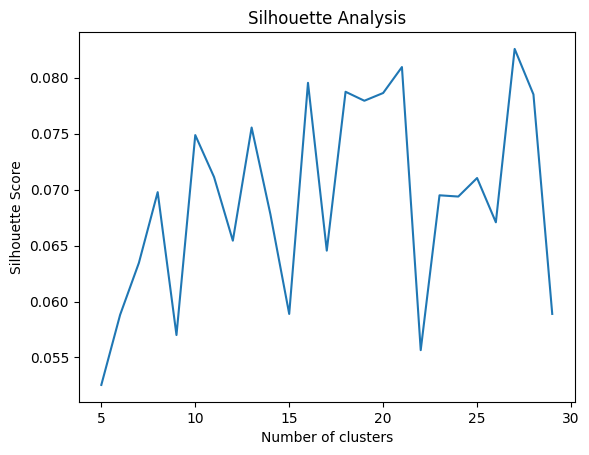

In [23]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

silhouette_scores = []
for i in range(5, 30):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

optimal_k = silhouette_scores.index(max(silhouette_scores))
print(optimal_k)
plt.plot(range(5, 30), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [24]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

labels = kmeans.labels_
print(labels)


# Group articles by cluster
clusters = {i: [] for i in range(optimal_k)}
for idx, label in enumerate(labels):
    clusters[label].append(cleaned_articles[idx])

c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 0 15 15  7 14 15  1 14  4  1 14  1 14  6  4  6  3  4  4 20  1  4  5 20
  4 15  1  7 21  7 15 21 10 15 15  7 21 11 10 15 21 15 21 20  1 10 10 21
 21 17 15  7  6  6  1  6  6  6  3  6  1  6  1 17  6  6  1  6  1  1  1  6
  6  1  1 12 12 18  5  5 12  5  5 19 12  5  5 11 12 11 18 12  5 18 16 12
 12  3 11 12  3  9 17  3  3  3 17  3 17 17 17 17 17 17  3  3  3 17  9 17
  9 17  9  9  3  0 14 14 14 14  4  0  0  0  0 20  0  0  0  7  4  0  1  4
  0 10 10  4  4 10 19 19  2  2  2  2 19 16  2  2 19 10  4  2 19  2 19 17
 19  2 19  2 19 19  2  8 16 16  8 16  8 13 16 16  8  4 19  1 11 16 13 16
  8 13  8 16 13 13 16 13]


In [25]:
for cluster,article in enumerate(clusters.values()):
  print('cluster ',cluster)
  for art in article:
    print(art)
  print(len(article))

cluster  0
{'title': "Former NFL star Drew Brees anxious to take another stab at broadcasting: 'Come get me'", 'description': "Although Drew Brees' stint as a broadcaster lasted just one year, he is now making it clear he is itching to take another shot at the job.", 'content': 'Drew Brees\' impressive NFL career came to an end after the 2020 season.He spent the next NFL season working as a color analyst. Brees worked in the booth alongside NBC\'s play-by-play announcer, Mike Tirico, for a pair of games during his stint at the network. He also worked on Notre Dame football games and appeared in the studio and on location at stadiums for "Football Night in America."\xa0Brees left the network in May 2022, citing his desire to spend more time with family. Now, the former quarterback appears eager to return to broadcasting.CLICK HERE FOR MORE SPORTS COVERAGE ON FOXNEWS.COMThe 45-year-old returned to the New Orleans Saints training site Thursday as the franchise unveiled plans to enshrine h

#### Cluster Goodness Metrics

In [1]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Assuming you have your data in a variable `X`
# Fit the KMeans++ model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate the Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# Calculate the Calinski-Harabasz Index
calinski_harabasz_avg = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")

# Calculate Inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


NameError: name 'optimal_k' is not defined

# Summarize each cluster

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

# # Save tokenizer and model
# tokenizer.save_pretrained("pegasus_model")
# model.save_pretrained("pegasus_model")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from transformers import pipeline


# Load tokenizer and model from the saved directory
tokenizer = AutoTokenizer.from_pretrained("pegasus_model")
model = AutoModelForSeq2SeqLM.from_pretrained("pegasus_model")


In [37]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pre-trained T5 model and tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)


c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\h4has\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adminis

In [51]:
def summarize_content(content, max_length):
    """
    Summarizes a single content to the specified maximum length.
    
    Args:
    - content (str): The content to be summarized.
    - max_length (int): The maximum length of the summary.
    
    Returns:
    - The summarized content.
    """
    # Summarize the content
    inputs = tokenizer.encode("summarize: " + content, return_tensors="pt", max_length=max_length, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=int(0.5 * max_length), length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [55]:
def summarize_cluster(cluster_texts, model_max_tokens = 1000): #7818):
    """
    Summarizes a cluster of texts by summarizing each individual text and concatenating the summaries.
    
    Args:
    - cluster_texts (list of dicts): List containing dictionaries with 'content' key for each news content in the cluster.
    
    Returns:
    - Summary of the concatenated news content within the cluster.
    """
    # Determine the maximum token limit per content
    max_token_limit_per_content = model_max_tokens // len(cluster_texts)
    
    # Summarize each content
    summarized_contents = []
    for text in cluster_texts:
        summarized_content = summarize_content(text['content'], max_token_limit_per_content)
        summarized_contents.append(summarized_content)
    
    # Concatenate the summarized contents
    cluster_summary = " ".join(summarized_contents)
    return cluster_summary

In [58]:
# Summarize each cluster
cluster_summaries = {}
for cluster_id, texts in clusters.items():
    summary = summarize_cluster(texts)
    cluster_summaries[cluster_id] = summary
    print(f"Cluster {cluster_id} Summary:")
    print(summary)

# # Print cluster-wise summaries
# for cluster_id, summary in cluster_summaries.items():
#     print(f"Cluster {cluster_id} Summary:")
#     print(summary)
#     print()


Cluster 0 Summary:
Drew Brees spent the next season working as a color analyst. he also worked on Notre Dame football games and appeared in the studio and on location at stadium. he also worked on a pair of games during his stint at the network. he also worked on Notre Dame football games and appeared in the studio. Drew Brees spent the next season working as a color analyst. he also worked on Notre Dame football games and appeared in the studio and on location at stadium. he also worked on a pair of games during his stint at the network. he also worked on Notre Dame football games and appeared in the studio. the upcoming bout between Mike Tyson and Jake Paul has been put on hold. the boxing match was originally scheduled to take place on July 20 in Arlington, Texas. but Tyson recently experienced health complications, which forced the postponement. despite the delay, Paul maintains that he will be able to return to the ring. angel Hernandez spent the past three decades as a baseball u

# Export summaries to database

# Next

1. automate the search for best hyperparamters values (for eps and min_samples)  -- DBSCAN Not working well -- check for problem

1. K-means any way to optimize cluster paramanters?
  -- Identify if clusters are dense/sparese using some metric like Inertia, Silhouette Score, etc.

2. More preprocessing -- see if needed -- maybe once more data is added
  
  2.1 Remove punctuations -- wait is this really needed? ouncs might be needed for summarizer tools to work better.

3. More data sources
  
  3.1 Include more time frame -- maybe a whole week
  
  3.2 More data sources -- possibly RSS feeds
  
4. Display titles as summaries and maybe also as tags on the screen -- the user selects what tags they want to explore -- think about this

  4.1. So we first group similar news -- and then summarize the content (take care not to skip important details)
  
  4.2. We then create a tag/title(of 1-4 words) for this group

1. Maybe look for better/faster ways to work the tokenizer and vectors. Explore batch prcessing and other tokenizer techniques -- nltk or Transformers?

5. Deployment -- dk yet - maybe think of some AWS deployment

6. CI/CD -- not sure yet







